# Disaster aware routing with openrouteservice

### Install and import necessary libraries

For this exercise we use the following R libraries:

-   `dplyr` for the ease of manipulating data.frame classes Wickham H, François R, Henry L, Müller K, Vaughan D (2023). *dplyr: A Grammar of Data Manipulation*. R package version 1.1.2, <https://CRAN.R-project.org/package=dplyr>.
-   `sf` the dplyr equivalent to work with spatial data.frames. Pebesma, E., & Bivand, R. (2023). Spatial Data Science: With Applications in R (1st ed.). Chapman and Hall/CRC. <https://doi.org/10.1201/9780429459016>
-   `openrouteservice` is the package that provides a user firendly R interface to the openrouteservice API. The package is not published on CRAN, therefore we install it via the `devtools` package from github.
-   `mapview` is a easy to use library to create interactive maps. Appelhans T, Detsch F, Reudenbach C, Woellauer S (2022). *mapview: Interactive Viewing of Spatial Data in R*. R package version 2.11.0, <https://CRAN.R-project.org/package=mapview>.

In [48]:
from openrouteservice import client
from openrouteservice.exceptions import ApiError
import geopandas as gpd
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import folium
from branca.colormap import linear
from shapely.geometry import Point, mapping
from ipyleaflet import Map, DrawControl, AwesomeIcon, Marker, GeoData, basemaps, LayersControl, Icon, GeoJSON

### Set up openrouteservice

In [83]:
# insert your ORS api key
api_key = ''
ors = client.Client(key=api_key)

## Simple route with avoid area  

### Normal route from disaster relief stagin area towards Bad Neuanahr-Ahrweiler 

In [100]:
start_point = (6.943241, 50.334265)
destination = (7.119166, 50.548979)

# Define parameters for request to openrouteservice
request_params = {'coordinates': [start_point, destination],
                 'format_out': 'geojson',
                 'profile': 'driving-hgv',
                 'preference': 'recommended',
                 'instructions': False}

Send request to ORS

In [5]:
route_directions = ors.directions(**request_params)

Convert ORS response to GeoDataFrame

In [9]:
route = gpd.GeoDataFrame().from_features(route_directions).set_crs(epsg=4326)

In [10]:
route.explore()

Plot route on map

avoid_polygons = {
    'type': 'FeatureCollection',
    'features': []
}

def handle_draw(self, action, geo_json):
    """Do something with the GeoJSON when it's drawn on the map"""    
    avoid_polygons['features'].append(geo_json)

m = Map(center=(7, 50.4), zoom=10, scroll_wheel_zoom=True, basemap=basemaps.CartoDB.Positron)

route_layer = GeoData(geo_dataframe = route,
                        name = 'Route Normal', 
                        style={"color": "red",
                               "opacity": 0.5})
m.add_layer(route_layer)
draw_control = DrawControl()
draw_control.polygon = {
    "shapeOptions": {
        "fillColor": "#6be5c3",
        "color": "#6be5c3",
        "fillOpacity": 1.0
    },
    "drawError": {
        "color": "#dd253b",
        "message": "Oups!"
    },
    "allowIntersection": False
}
draw_control.on_draw(handle_draw)
m.add_control(draw_control)
m

#### Send request again with avoided polygon


request_params['options'] = {'avoid_polygons': avoid_polygons['features'][0]['geometry']}
route_directions_avoided = ors.directions(**request_params)
route_avoided = gpd.GeoDataFrame().from_features(route_directions_avoided)

m = Map(center=start_point[::-1], zoom=10, scroll_wheel_zoom=True, basemap=basemaps.CartoDB.Positron)

route_layer = GeoData(geo_dataframe = route,
                        name = 'Route Normal', 
                        style={"color": "green",
                               "opacity": 0.5})
m.add_layer(route_layer)

route_avoided_layer = GeoData(geo_dataframe = route_avoided,
                        name = 'Route Avoided', 
                        style={"color": "red",
                               "opacity": 0.5})
m.add_layer(route_avoided_layer)

avoided_polygon = GeoData(geo_dataframe = gpd.GeoDataFrame().from_features(avoid_polygons),
                        name = 'Avoided polygon', 
                        style={"color": "blue", "fillColor": None, 'alpha': 0, "fillOpacity": 1,
                               "opacity": 0.5})
m.add_layer(avoided_polygon)

m
### Load affected roads and places 

The basecamp where the rescue helpers were stationed is the Nürburgring

In [117]:
basecamp_coordinates = (6.943488121032716, 50.33214859082482)
basecamp = gpd.GeoDataFrame({'geometry': [Point(basecamp_coordinates)], 'name': ['Base Camp']}, crs="epsg:4326")

In [118]:
affected_roads_bridges = gpd.read_file("../resources/data/ahrtal/affected_roads.gpkg")
affected_roads_bridges['id'] = affected_roads_bridges.index
affected_places = gpd.read_file("../resources/data/ahrtal/affected_places.gpkg")

Buffer the damaged bridges and roads by 2 meters to convert them into polygons

In [119]:
affected_roads_bridges_union = affected_roads_bridges.copy()
affected_roads_bridges_union.geometry = affected_roads_bridges_union.geometry.to_crs('25832').buffer(2).to_crs('4326').make_valid()
affected_roads_bridges_union = affected_roads_bridges_union.dissolve()
affected_roads_bridges_union.geometry = affected_roads_bridges_union.make_valid()

In [120]:
m = affected_roads_bridges.explore(color='red',
                                  tooltip=['id'])
affected_places.explore(m=m, 
                        color='blue')

### Calculate routes from base camp to the affected places 

First, we need to add the affected roads and bridges to the quer parameters as areas to avoid.

In [121]:
request_params_flood = request_params.copy()
request_params_flood['options'] = {'avoid_polygons': mapping(affected_roads_bridges_union.make_valid().geometry[0])}

In [122]:
normal_routes = []
avoiding_routes = []

for i, p in affected_places.iterrows():

    # Calculate route before the flood
    request_params['coordinates'] = [basecamp_coordinates, (p.geometry.x, p.geometry.y)]
    directions_normal = ors.directions(**request_params)
    directions_normal_df = gpd.GeoDataFrame().from_features(directions_normal)
    directions_normal_df['name'] = p['name']
    directions_normal_df['id'] = i

    # Calculate route after the flood
    try:
        request_params_flood['coordinates'] = [basecamp_coordinates, (p.geometry.x, p.geometry.y)]
        directions_flood = ors.directions(**request_params_flood)
        directions_flood_df = gpd.GeoDataFrame().from_features(directions_flood)
        directions_flood_df['name'] = p['name']
        directions_flood_df['id'] = i
    except ApiError as e:
        print(e)
        print(f"No route found for {p['name']}")
        continue
    
    avoiding_routes.append(directions_flood_df)    
    normal_routes.append(directions_normal_df)


404 ({'error': {'code': 2009, 'message': 'Route could not be found - Unable to find a route between points 1 (6.9434881 50.3321486) and 2 (7.0369358 50.5153844).'}, 'info': {'engine': {'version': '6.8.1', 'build_date': '2023-05-22T14:27:28Z'}, 'timestamp': 1687607213803}})
No route found for Rech 2
404 ({'error': {'code': 2009, 'message': 'Route could not be found - Unable to find a route between points 1 (6.9434881 50.3321486) and 2 (6.9482579 50.4691076).'}, 'info': {'engine': {'version': '6.8.1', 'build_date': '2023-05-22T14:27:28Z'}, 'timestamp': 1687607215428}})
No route found for Hönningen 2
404 ({'error': {'code': 2009, 'message': 'Route could not be found - Unable to find a route between points 1 (6.9434881 50.3321486) and 2 (7.0579673 50.5358548).'}, 'info': {'engine': {'version': '6.8.1', 'build_date': '2023-05-22T14:27:28Z'}, 'timestamp': 1687607218961}})
No route found for Marienthal
404 ({'error': {'code': 2009, 'message': 'Route could not be found - Unable to find a route

/Users/cludwig/Documents/conferences/2023_FOSS4G/workshop/openrouteservice-examples/.venv/lib/python3.9/site-packages/openrouteservice/client.py:211: UserWarning: Rate limit exceeded. Retrying for the 1st time.
  warnings.warn('Rate limit exceeded. Retrying for the {0}{1} time.'.format(retry_counter + 1,
/Users/cludwig/Documents/conferences/2023_FOSS4G/workshop/openrouteservice-examples/.venv/lib/python3.9/site-packages/openrouteservice/client.py:211: UserWarning: Rate limit exceeded. Retrying for the 2nd time.
  warnings.warn('Rate limit exceeded. Retrying for the {0}{1} time.'.format(retry_counter + 1,
/Users/cludwig/Documents/conferences/2023_FOSS4G/workshop/openrouteservice-examples/.venv/lib/python3.9/site-packages/openrouteservice/client.py:211: UserWarning: Rate limit exceeded. Retrying for the 3rd time.
  warnings.warn('Rate limit exceeded. Retrying for the {0}{1} time.'.format(retry_counter + 1,
/Users/cludwig/Documents/conferences/2023_FOSS4G/workshop/openrouteservice-example

404 ({'error': {'code': 2009, 'message': 'Route could not be found - Unable to find a route between points 1 (6.9434881 50.3321486) and 2 (6.9730776 50.4900072).'}, 'info': {'engine': {'version': '6.8.1', 'build_date': '2023-05-22T14:27:28Z'}, 'timestamp': 1687607291595}})
No route found for Brück 2
404 ({'error': {'code': 2009, 'message': 'Route could not be found - Unable to find a route between points 1 (6.9434881 50.3321486) and 2 (6.9863594 50.5106587).'}, 'info': {'engine': {'version': '6.8.1', 'build_date': '2023-05-22T14:27:28Z'}, 'timestamp': 1687607292552}})
No route found for Altenburg
404 ({'error': {'code': 2009, 'message': 'Route could not be found - Unable to find a route between points 1 (6.9434881 50.3321486) and 2 (6.8918454 50.4475365).'}, 'info': {'engine': {'version': '6.8.1', 'build_date': '2023-05-22T14:27:28Z'}, 'timestamp': 1687607297069}})
No route found for Schuld 3
404 ({'error': {'code': 2009, 'message': 'Route could not be found - Unable to find a route be

In [104]:
normal_routes_df = gpd.GeoDataFrame(pd.concat(normal_routes)).set_crs(epsg=4326).set_index('id')
avoiding_routes_df = gpd.GeoDataFrame(pd.concat(avoiding_routes)).set_crs(epsg=4326).set_index('id')

In [105]:
normal_routes_df['duration'] = normal_routes_df.summary.map(lambda x: x['duration'])
avoiding_routes_df['duration'] = avoiding_routes_df.summary.map(lambda x: x['duration'])

In [106]:
avoiding_routes_df = avoiding_routes_df.join(normal_routes_df[['duration']], lsuffix='_avoid')
avoiding_routes_df['duration_difference'] = (avoiding_routes_df.duration_avoid - avoiding_routes_df.duration) / 60. 
avoiding_routes_df['duration_difference_%'] = (avoiding_routes_df.duration_avoid - avoiding_routes_df.duration) / avoiding_routes_df.duration_avoid * 100. 

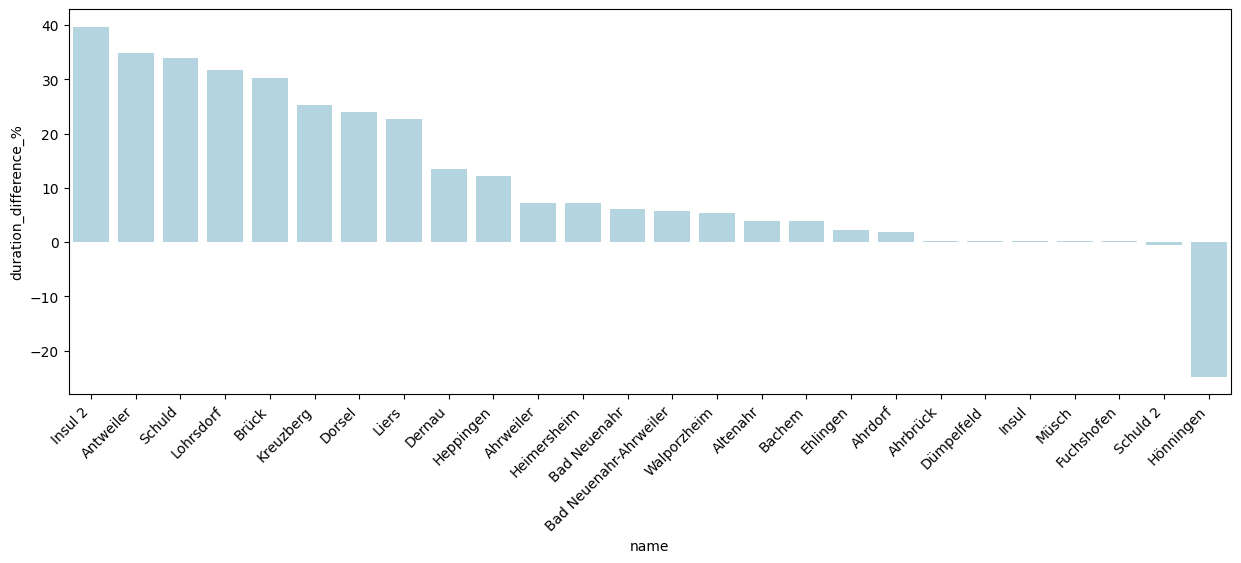

In [108]:
fig, axes = plt.subplots(1,1, figsize=(15, 5))
sns.barplot(data=avoiding_routes_df.sort_values('duration_difference_%', ascending=False), 
            x='name', y='duration_difference_%', color='lightblue',
           ax=axes)
g = plt.xticks(rotation = 45, ha='right') # Rotates X-Axis Ticks by 45-degrees

In [112]:
affected_places_dur = affected_places.join(avoiding_routes_df[['duration_difference', 'duration_difference_%']])
#affected_places_dur = affected_places_dur.loc[affected_places_dur['name'] != 'Hönningen']

In [116]:
place_name = 'Hönningen'
m = affected_places_dur.explore(column='duration_difference_%', 
                            tooltip=['name', 'duration_difference_%','duration_difference'],
                            popup=True,  # show all values in popup (on click)
                            tiles="CartoDB positron",  # use "CartoDB positron" tiles
                            cmap='Reds', vmin=0, vmax=affected_places_dur['duration_difference_%'].max(),
                            marker_kwds=dict(radius=10, fill=True))

basecamp.explore(
    m=m,
    marker_type='marker',
    marker_kwds={'icon': folium.map.Icon(icon='people')},
    color="orange", 
    #marker_kwds=dict(radius=10, fill=True)
)
avoiding_routes_df.loc[avoiding_routes_df['name'] == place_name].explore(
    m=m,
    highlight=True,
    name='Route after flood',
    legend=True,
    tooltip=['name', 'duration'],
    popup=True,
    color="lightpink")
#normal_routes_df.loc[normal_routes_df['name'] == place_name].explore(
#    m=m,
#    name='Route before flood',
#    tooltip=['name', 'duration'],
#    popup=True,
#    color="green")
affected_roads_bridges.explore(m=m, 
                               color='red',
                                 tooltip=['id'],
 
                              )
m

## Isochrones

In [51]:
isochrones_parameters = {
    'locations': [basecamp_coordinates],
    'profile': 'driving-car',
    'range_type': 'time',
    'range': [60 * 60],  # 900/60 = 15 minutes # Get population count for isochrones
}

In [ ]:
isochrones = ors.isochrones(**isochrones_parameters)
isochrones_df = gpd.GeoDataFrame.from_features(isochrones).set_crs(epsg=4326)

In [86]:
m = affected_places.explore(tooltip=['name'],
                            popup=True,  # show all values in popup (on click)
                            tiles="CartoDB positron", 
                            color='red',
                            marker_kwds=dict(radius=10, fill=True))

basecamp.explore(
    m=m,
    marker_type='marker',
    marker_kwds={'icon': folium.map.Icon(icon='people')},
    color="orange", 
    #marker_kwds=dict(radius=10, fill=True)
)
affected_roads_bridges.explore(m=m, 
                               color='red',
                                 tooltip=['id'],
 
                              )
isochrones_df.explore(m=m)